# Gradient Boosting

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import warnings

In [2]:
# Preprocessing
from transformers import AverageTransformer, DateTransformer, CyclicalTransformer, SimpleDateTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

In [3]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

In [4]:
#Data
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913


## Evaluation Framework

In [5]:
# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Evaluation
from functions import *

# Scoring Metrics
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
r2 = make_scorer(r2_score)

In [6]:
# Drop redundant features
drop = ('drop', ['rv1', 'rv2'])

# Transformation Columns for Average Transform
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

# Transformations
dt = DateTransformer(['date'])
ct = CyclicalTransformer(['date'])
sdt = SimpleDateTransformer(['date'])
t_at = AverageTransformer(T_cols, ['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])

In [7]:
# Scalers
ss = StandardScaler()
pt = PowerTransformer()
qt = QuantileTransformer()

In [8]:
# Models
gbr = GradientBoostingRegressor()
xgb = xgboost.XGBRegressor()

## Gradient Boosting Regressor
Gradient Boosting is a boosting ensemble method that iterates to improve on the residual errors from the previous estimator. As the data is clearly heteroscedastic and there is a lot of variance in the target feature, this model should perform much better than linear regression. 

In [9]:
gbr_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')
gbr_pipeline = make_pipeline(gbr_preprocess, gbr)

params = [{
    'gradientboostingregressor':[gbr]
}]

gbr_gs = GridSearchCV(gbr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
gbr_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'gradientboostingregressor': [GradientBoostingRegressor()]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [10]:
# Best model so far
gbr_best = gbr_gs.best_estimator_

In [11]:
rmse_loss = max(gbr_gs.cv_results_['mean_test_rmse'])
r2_score = max(gbr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -85.622
average r squared: 0.314


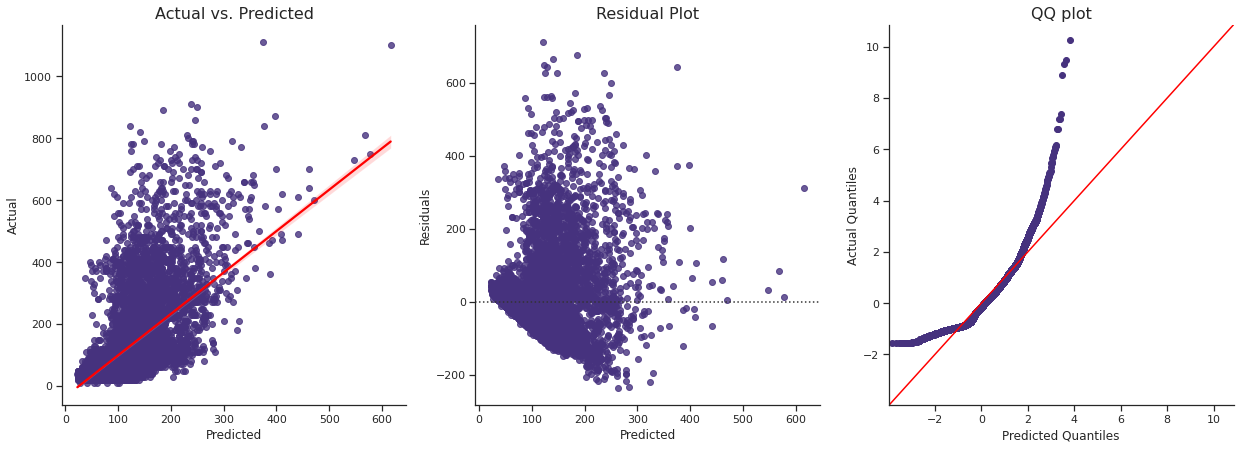

In [12]:
residual_plots(gbr_best, X, y)

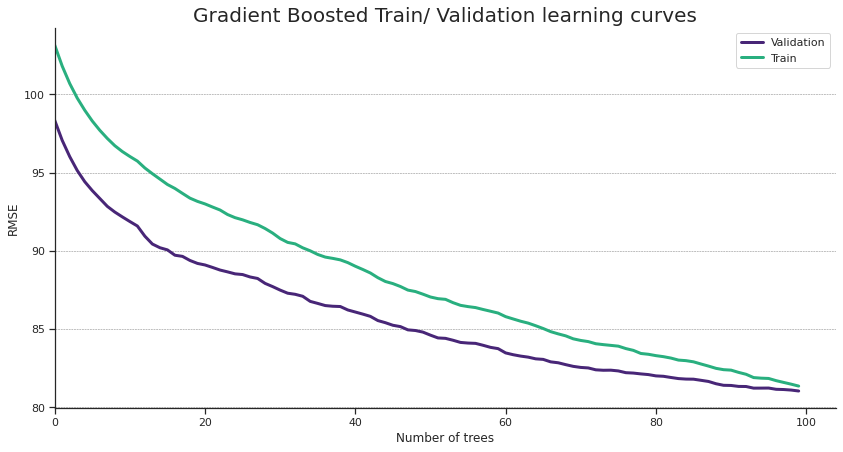

In [13]:
gbr_learning_curves(gbr_best, X, y)

Gradient Boosting seems to work very well, right out of the box. The learning curves indicate that there is more optimsation to be done, and the validation set may be easy to predict. Adding additional complexity to the model and hyperparameter tuning might provide better results. 

#### Random Variables
Out of curiosity, let's include the random variables that we removed from the exploratory data step. Let's also check to see if changing any of the date transformations improves performance. 

In [14]:
gbr_preprocess = make_column_transformer((ct, ['date']), remainder='passthrough')
gbr_pipeline = make_pipeline(gbr_preprocess, gbr)

params = [{
    'columntransformer__cyclicaltransformer':[dt, sdt, ct]
}]

gbr_gs = GridSearchCV(gbr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
gbr_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'columntransformer__cyclicaltransformer': [DateTransformer(date=['date']),
                                                                     SimpleDateTransformer(date=['date']),
                                                                     CyclicalTransformer(cyclical_features=['date'])]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [15]:
rmse_loss = max(gbr_gs.cv_results_['mean_test_rmse'])
r2_score = max(gbr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -85.609
average r squared: 0.314


There was neglible change from the base model, confirming that the two variables are just random noise and do not attribute any value to the models.

## Hyperparameter Tuning

In [16]:
gbr_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')

params = [{
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__max_depth':[6, 7, 8 ],
}]

gbr_gs = GridSearchCV(gbr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
gbr_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'gradientboostingregressor__max_depth': [6, 7, 8],
                          'gradientboostingregressor__n_estimators': [100,
                                                                      200]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [17]:
rmse_loss = max(gbr_gs.cv_results_['mean_test_rmse'])
r2_score = max(gbr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -71.237
average r squared: 0.526


In [18]:
# Best model so far
gbr_best = gbr_gs.best_estimator_

In [19]:
results = pd.DataFrame(gbr_gs.cv_results_)[['param_gradientboostingregressor__n_estimators', 'param_gradientboostingregressor__max_depth', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__max_depth,mean_test_rmse,mean_test_r2
5,200,8,-71.236803,0.525833
3,200,7,-72.566436,0.507776
4,100,8,-72.633905,0.506986
1,200,6,-73.648865,0.492703
2,100,7,-74.474446,0.481363
0,100,6,-76.270687,0.456089


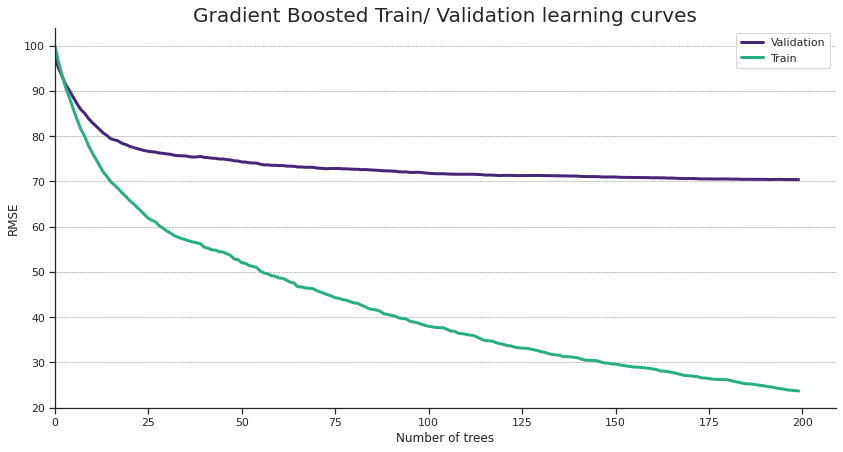

In [20]:
gbr_learning_curves(gbr_best, X, y)

The learning curves from the gradient boosting show that there is still high variance and the model is overfitting. To overcome this, simplifying the data might be possible, as well as other regularisation techniques such as shrinkage and subsampling to achieve stochastic gradient boosting.

In [21]:
gbr_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')

params = [{
    'gradientboostingregressor__n_estimators': [200, 400, 800],
    'gradientboostingregressor__max_depth':[8],
    'gradientboostingregressor__subsample':[0.25],
    'gradientboostingregressor__learning_rate': np.linspace(0.01, 1, 5)*0.1
}]

gbr_gs = GridSearchCV(gbr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
gbr_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'gradientboostingregressor__learning_rate': array([0.001  , 0.02575, 0.0505 , 0.07525, 0.1    ]),
                          'gradientboostingregressor__max_depth': [8],
                          'gradientboostingregressor__n_estimators': [200, 400,
                                                                      800],
                          'gradientboostingregressor__subsample': [0.25]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [22]:
rmse_loss = max(gbr_gs.cv_results_['mean_test_rmse'])
r2_score = max(gbr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -71.991
average r squared: 0.516


In [23]:
# Best model so far
gbr_best = gbr_gs.best_estimator_

In [24]:
results = pd.DataFrame(gbr_gs.cv_results_)[['param_gradientboostingregressor__n_estimators', 'param_gradientboostingregressor__max_depth', 'param_gradientboostingregressor__learning_rate', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__learning_rate,mean_test_rmse,mean_test_r2
8,800,8,0.0505,-71.991165,0.515544
5,800,8,0.02575,-73.368221,0.496608
11,800,8,0.07525,-73.375533,0.496438
7,400,8,0.0505,-74.228625,0.484828
10,400,8,0.07525,-74.422971,0.481769
14,800,8,0.1,-74.763865,0.476806
13,400,8,0.1,-74.838414,0.476088
4,400,8,0.02575,-75.599645,0.465645
9,200,8,0.07525,-76.502231,0.452645
6,200,8,0.0505,-76.658467,0.450604


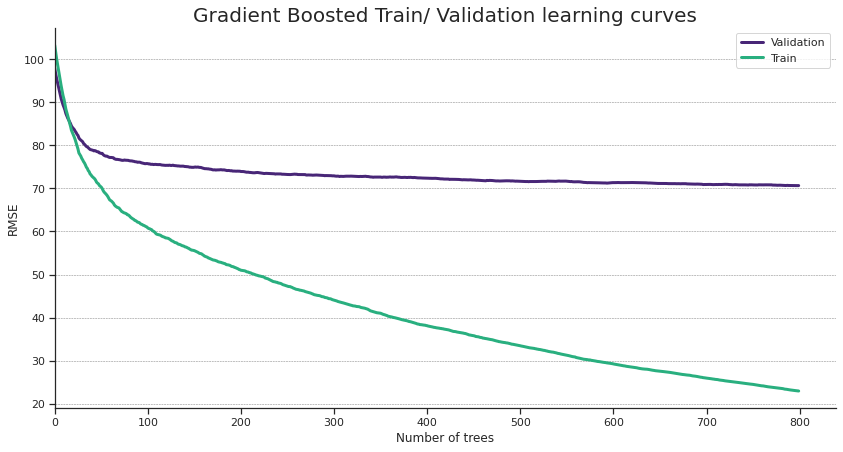

In [25]:
gbr_learning_curves(gbr_best, X, y)

In [26]:
params = [{
    'gradientboostingregressor__n_estimators': [800, 1000],
    'gradientboostingregressor__max_depth':[8],
    'gradientboostingregressor__subsample':[0.25],
    'gradientboostingregressor__learning_rate': np.linspace(0.04, 0.08, 5)
}]

gbr_gs = GridSearchCV(gbr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
gbr_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'gradientboostingregressor__learning_rate': array([0.04, 0.05, 0.06, 0.07, 0.08]),
                          'gradientboostingregressor__max_depth': [8],
                          'gradientboostingregressor__n_estimators': [800,
                                                                      1000],
                          'gradientboostingregressor__subsample': [0.25]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [27]:
results = pd.DataFrame(gbr_gs.cv_results_)[['param_gradientboostingregressor__n_estimators', 'param_gradientboostingregressor__learning_rate', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__learning_rate,mean_test_rmse,mean_test_r2
1,1000,0.04,-71.868371,0.516766
2,800,0.05,-72.153166,0.513250
3,1000,0.05,-72.154260,0.513142
5,1000,0.06,-72.404892,0.509278
0,800,0.04,-72.431921,0.509440
6,800,0.07,-72.747156,0.504844
7,1000,0.07,-72.857764,0.503529
8,800,0.08,-73.087005,0.500428
9,1000,0.08,-73.098884,0.499829
4,800,0.06,-73.140552,0.499404


In [28]:
# Best model so far
gbr_best = gbr_gs.best_estimator_

#### Early Stopping

In [29]:
X_trans = gbr_best['columntransformer'].fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_trans, y)
gbr_best['gradientboostingregressor'].fit(X_train, y_train)

val_errors = [mean_squared_error(y_val, y_val_hat, squared=False) for y_val_hat in gbr_best['gradientboostingregressor'].staged_predict(X_val)]
train_errors = [mean_squared_error(y_train, y_train_hat, squared=False) for y_train_hat in gbr_best['gradientboostingregressor'].staged_predict(X_train)]
best_estimators = np.argmin(val_errors) + 1

gbr_best['gradientboostingregressor'].set_params(n_estimators=best_estimators)
gbr_best['gradientboostingregressor'].fit(X_train, y_train)
print(f'stopping at {best_estimators} trees')

stopping at 983 trees


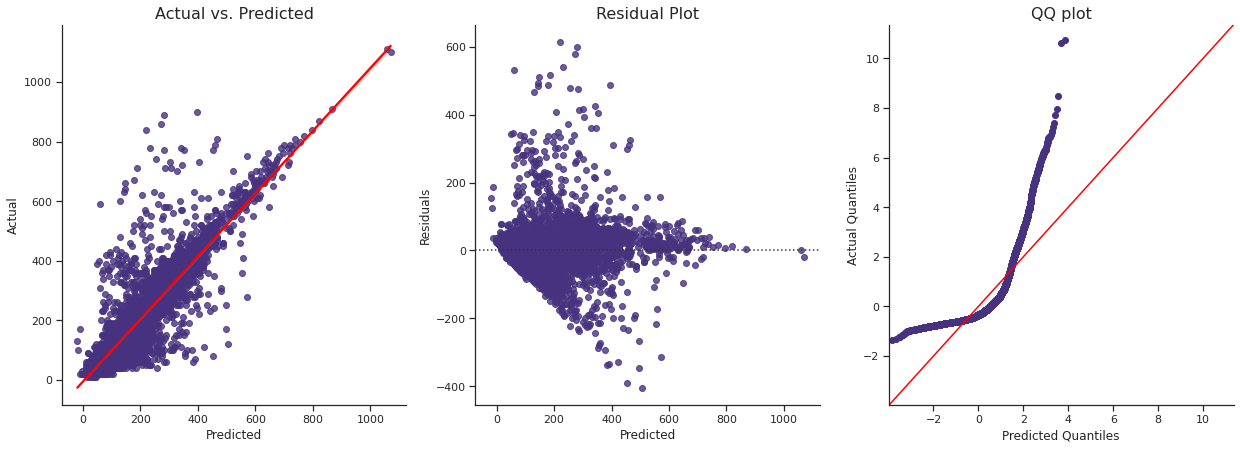

In [30]:
residual_plots(gbr_best, X, y)

The optimised model performs excellently, and the residual plots can be seen to form a much better pattern than previous attempts. The model was tuned to contain just under 1000 gradient boosted trees, which was helped by early stopping when the validation set stopped improving. The low learning rate acted as a method to regularise the model and prevent overfitting.

In [31]:
filename = 'models/gbr_best.sav'
joblib.dump(gbr_best, filename)

['models/gbr_best.sav']

## XGBoost

In [32]:
xgb_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')
xgb_pipeline = make_pipeline(xgb_preprocess, xgb)

params = [{
    'xgbregressor':[xgb]
}]

xgb_gs = GridSearchCV(xgb_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
xgb_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=N...
                                                        max_delta_step=None,
                                                        max_depth=None,
                                                        max_leaves=None,
                                                        min_child_weight=None,
                                                        missing=nan,
                                                        monotone_constraints=None,
                                                        n_estimators=100,
                                                        n_jobs=None,
                                                        num_parallel_tree=None,
                                                        predictor=None,
                                                        random_state=None,
                                                        reg_alpha=None,
                                                        reg_lambda=None, ...)]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [33]:
# Best model so far
xgb_best = xgb_gs.best_estimator_

In [34]:
rmse_loss = max(xgb_gs.cv_results_['mean_test_rmse'])
r2_score = max(xgb_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -72.166
average r squared: 0.512


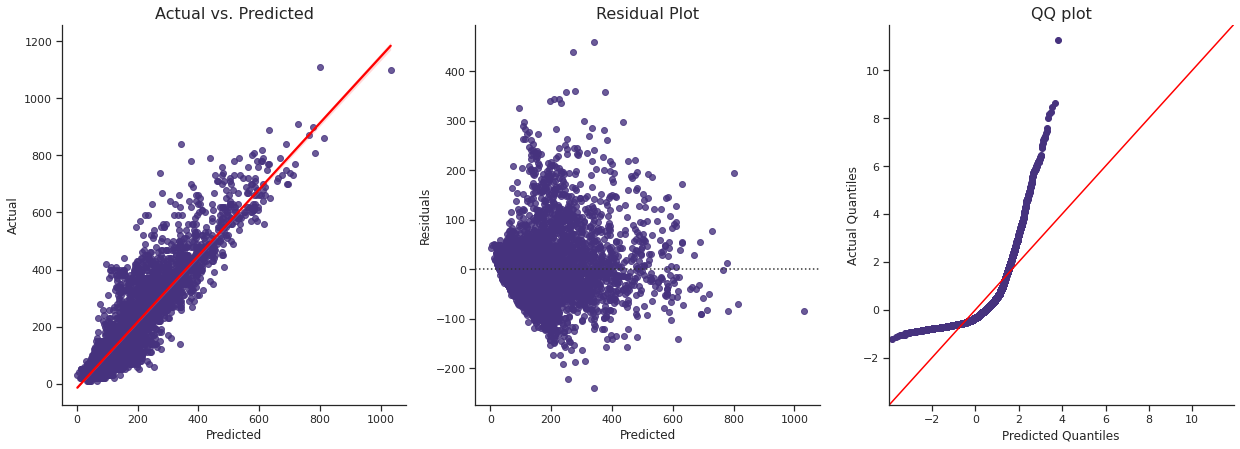

In [35]:
residual_plots(xgb_best, X, y)

XGBoost works even better out of the box than gradient boost did.

## Hyperparameter Tuning

In [36]:
params = [{
    'xgbregressor__n_estimators':[400, 800, 1000]
}]

xgb_gs = GridSearchCV(xgb_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
xgb_gs.fit(X, y)


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     co...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid=[{'xgbregressor__n_estimators': [400, 800, 1000]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [37]:
rmse_loss = max(xgb_gs.cv_results_['mean_test_rmse'])
r2_score = max(xgb_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -71.007
average r squared: 0.528


In [38]:
results = pd.DataFrame(xgb_gs.cv_results_)[['param_xgbregressor__n_estimators', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_xgbregressor__n_estimators,mean_test_rmse,mean_test_r2
2,1000,-71.006524,0.528190
1,800,-71.066439,0.527387
0,400,-71.542288,0.521090


In [39]:
# Best model so far
xgb_best = xgb_gs.best_estimator_

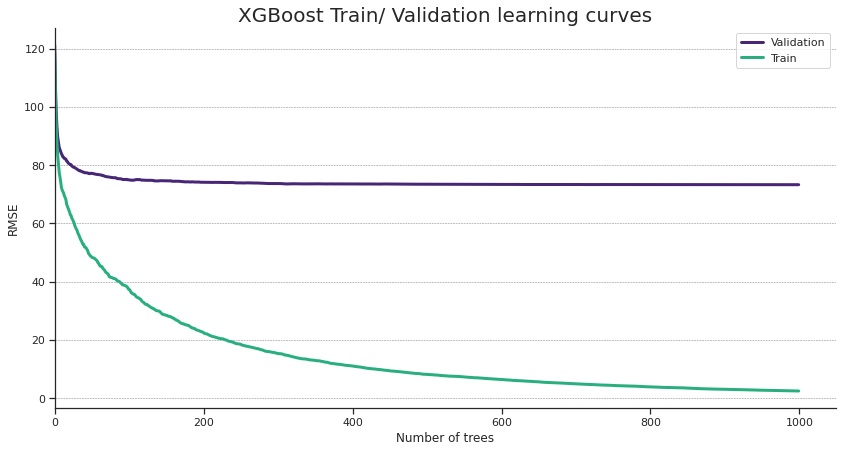

In [40]:
xgb_learning_curves(xgb_best, X, y)

In [41]:
rmse_loss = max(xgb_gs.cv_results_['mean_test_rmse'])
r2_score = max(xgb_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -71.007
average r squared: 0.528


In [42]:
params = [{
    'xgbregressor__n_estimators':[1000],
    'xgbregressor__learning_rate':np.linspace(0.01, 0.2, 10)
}]

xgb_gs = GridSearchCV(xgb_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
xgb_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     co...
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid=[{'xgbregressor__learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                          'xgbregressor__n_estimators': [1000]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [43]:
results = pd.DataFrame(xgb_gs.cv_results_)[['param_xgbregressor__n_estimators', 'param_xgbregressor__learning_rate', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_xgbregressor__n_estimators,param_xgbregressor__learning_rate,mean_test_rmse,mean_test_r2
6,1000,0.136667,-69.165991,0.552459
8,1000,0.178889,-69.169960,0.552497
7,1000,0.157778,-69.324507,0.550377
4,1000,0.094444,-69.515090,0.547896
5,1000,0.115556,-69.741524,0.545104
9,1000,0.2,-69.801699,0.544033
3,1000,0.073333,-70.026470,0.541292
2,1000,0.052222,-70.150389,0.539867
1,1000,0.031111,-71.876987,0.516930
0,1000,0.01,-76.681242,0.450365


In [44]:
rmse_loss = max(xgb_gs.cv_results_['mean_test_rmse'])
r2_score = max(xgb_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -69.166
average r squared: 0.552


In [45]:
# Best model so far
xgb_best = xgb_gs.best_estimator_

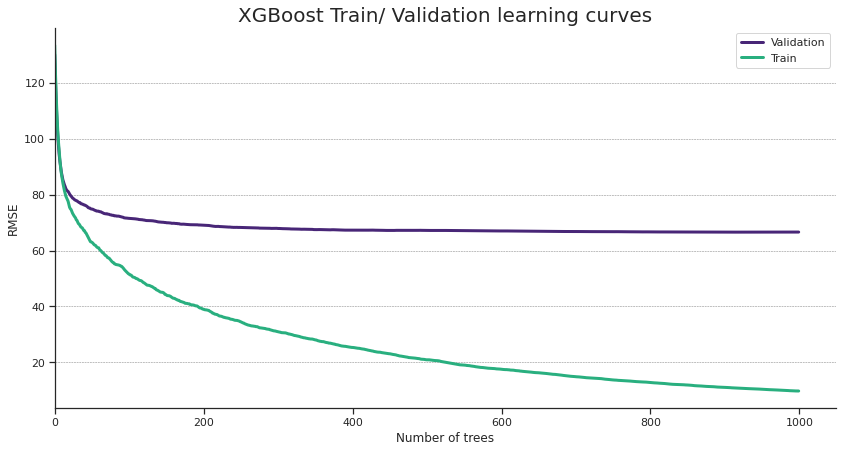

In [46]:
xgb_learning_curves(xgb_best, X, y)

In [47]:
params = [{
    'xgbregressor__subsample':[0.4, 0.5, 0.6],
    'xgbregressor__colsample_bytree':[0.5, 1]
}]

xgb_gs = GridSearchCV(xgb_best, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
xgb_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     callbacks=None,
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsa...
                                                     monotone_constraints='()',
                                                     n_estimators=1000,
                                                     n_jobs=0,
                                                     num_parallel_tree=1,
                                                     predictor='auto',
                                                     random_state=0,
                                                     reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid=[{'xgbregressor__colsample_bytree': [0.5, 1],
                          'xgbregressor__subsample': [0.4, 0.5, 0.6]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [48]:
results = pd.DataFrame(xgb_gs.cv_results_)[['param_xgbregressor__subsample', 'param_xgbregressor__colsample_bytree', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_xgbregressor__subsample,param_xgbregressor__colsample_bytree,mean_test_rmse,mean_test_r2
5,0.6,1,-68.865310,0.556280
2,0.6,0.5,-69.032242,0.554433
4,0.5,1,-69.041832,0.553830
1,0.5,0.5,-69.384008,0.549615
0,0.4,0.5,-69.806614,0.543779
3,0.4,1,-69.971902,0.541345


In [49]:
# Best model so far
xgb_best = xgb_gs.best_estimator_

In [50]:
params = [{
    'xgbregressor__max_depth':[4, 6, 8],
    'xgbregressor__lambda':np.linspace(5, 15, 3)
}]

xgb_gs = GridSearchCV(xgb_best, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
xgb_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     callbacks=None,
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsa...
                                                     monotone_constraints='()',
                                                     n_estimators=1000,
                                                     n_jobs=0,
                                                     num_parallel_tree=1,
                                                     predictor='auto',
                                                     random_state=0,
                                                     reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid=[{'xgbregressor__lambda': array([ 5., 10., 15.]),
                          'xgbregressor__max_depth': [4, 6, 8]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [51]:
results = pd.DataFrame(xgb_gs.cv_results_)[['param_xgbregressor__lambda', 'param_xgbregressor__max_depth', 'mean_test_rmse', 'mean_test_r2',]]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
results

,param_xgbregressor__lambda,param_xgbregressor__max_depth,mean_test_rmse,mean_test_r2
2,5.0,8,-67.682223,0.571272
5,10.0,8,-67.682223,0.571272
8,15.0,8,-67.682223,0.571272
1,5.0,6,-68.865310,0.556280
4,10.0,6,-68.865310,0.556280
7,15.0,6,-68.865310,0.556280
0,5.0,4,-71.398367,0.523308
3,10.0,4,-71.398367,0.523308
6,15.0,4,-71.398367,0.523308


In [52]:
# Best model so far
xgb_best = xgb_gs.best_estimator_

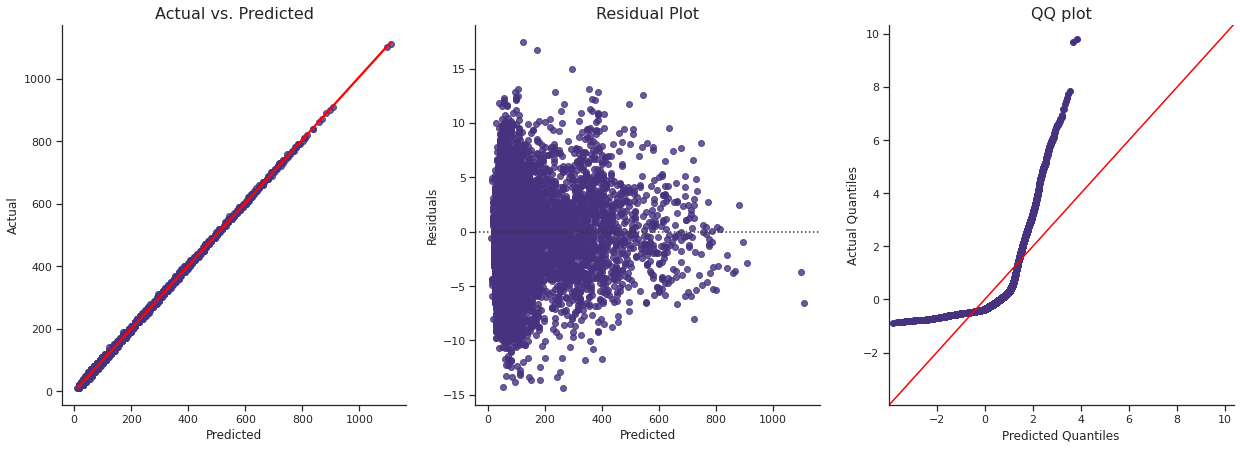

In [53]:
residual_plots(xgb_best, X, y)

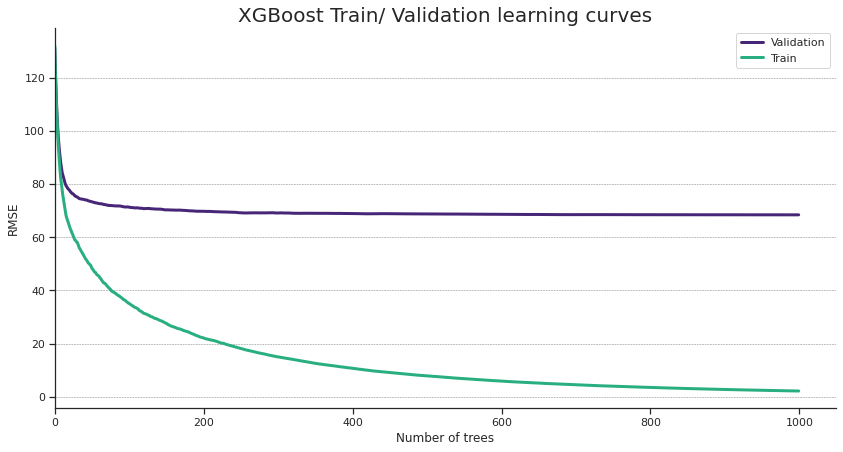

In [54]:
xgb_learning_curves(xgb_best, X, y)

There seem to only be small iterative improvements able to be made from hyperparameter tuning at this stage, with the validation errors plateauting rather quickly.

#### Exporting the model

In [58]:
filename = 'models/xgb_best.sav'
joblib.dump(xgb_best, filename)

['models/xgb_best.sav']